# Analysis of climbing data

In [1]:
import calendar
import collections
import shelve
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table

import core

In [2]:
with shelve.open("climbing_days") as data:
    climbing_days: dict[str, core.ClimbingDay] = dict(data)

In [3]:
sorted(climbing_days.keys())[:10]

['2021-04-07',
 '2021-04-09',
 '2021-04-24',
 '2021-05-07',
 '2021-05-08',
 '2021-05-09',
 '2021-05-13',
 '2021-05-14',
 '2021-05-24',
 '2021-06-05']

In [4]:
climbing_day = climbing_days["2024-04-09"]

In [5]:
type(climbing_day)

core.ClimbingDay

In [6]:
pprint(climbing_days["2024-05-18"].climb_entries[-1])

ClimbEntry(name_approx='Restless Native',
           comment='TA, first try in many years, stopped at low crux not very '
                   'close, beta all wrong',
           climbers=['TA', 'AS'],
           climb_info=ClimbInfo(name='Restless Native',
                                grade='12c',
                                aliases=['Restless Native']),
           climb_events=[ClimbEvent(climber='TA', hang=True)],
           idx_entry_start=48)


In [7]:
climbing_days["2024-05-18"].climb_entries[-1].climb_events[0]

ClimbEvent(climber='TA', hang=True)

In [8]:
import re
from functools import cached_property


class Grade:
    def __init__(self, grade):
        if isinstance(grade, str):
            self.grade = grade
        elif hasattr(grade, "grade") and isinstance(grade.grade, str):
            self.grade = grade.grade
        else:
            raise ValueError(f"Cannot convert {grade} to Grade object.")

    @cached_property
    def number_mod(self) -> tuple[int, str]:
        """Convert grade like 12a/b to (12, "a/b") and 12+ to (12, "c/d").

        This allows for easy comparison of grades.
        """
        grade_str = self.grade
        if grade_str.startswith("5."):
            grade_str = grade_str[2:]
        number, modifier = re.match(r"(\d+)([^\d]*)", grade_str).groups()
        number = int(number)
        if modifier == "-":
            modifier = "a/b"
        if modifier == "+":
            modifier = "c/d"
        return number, modifier

    def __repr__(self):
        return self.grade

    def __hash__(self):
        return hash(self.grade)

    def __eq__(self, other):
        return self.number_mod == Grade(other).number_mod

    def __ne__(self, other):
        return not self == other

    def __le__(self, other):
        return self.number_mod <= Grade(other).number_mod

    def __gt__(self, other):
        return not self <= other

    def __lt__(self, other):
        return self.number_mod < Grade(other).number_mod

    def __ge__(self, other):
        return not self < other

In [9]:
g1 = Grade("5.10-")
print(g1)
g2 = Grade("5.10b")
print('g1 < "12a"', g1 < "12a")
print('"12a" < g1', "12a" < g1)
print('"9+" < g1', "9+" < g1)
print('"9+" < "9-"', "9+" < "9-")
print('Grade("9+") < "9-"', Grade("9+") < "9-")

5.10-
g1 < "12a" True
"12a" < g1 False
"9+" < g1 True
"9+" < "9-" True
Grade("9+") < "9-" False


In [10]:
def get_climbs_table(climbing_days: dict[str, core.ClimbingDay]) -> Table:
    """Flatten climbing days hierarchical data structure to an astropy table."""
    rows = []
    for date in climbing_days:
        for entry in climbing_days[date].climb_entries:
            for event in entry.climb_events:
                rows.append(
                    (
                        date,
                        entry.climb_info.name,
                        Grade(entry.climb_info.grade),
                        event.climber,
                        "" if event.hang else "✓",
                    )
                )
    climbs = Table(rows=rows, names=("date", "name", "grade", "climber", "send"))
    climbs.sort("date")
    climbs["year"] = np.array([int(date.split("-")[0]) for date in climbs["date"]])
    climbs["month"] = np.array([int(date.split("-")[1]) for date in climbs["date"]])
    climbs["grade_num"] = np.array([grade.number_mod[0] for grade in climbs["grade"]])

    return climbs

In [11]:
climbs = get_climbs_table(climbing_days)

In [12]:
climbs

date,name,grade,climber,send,year,month,grade_num
str10,str24,object,str2,str1,int64,int64,int64
2021-04-07,Holderness Arete,10b,TA,✓,2021,4,10
2021-04-07,Idiot Deluxe,10c,AS,✓,2021,4,10
2021-04-07,Idiot Deluxe,10c,TA,✓,2021,4,10
2021-04-07,Holderness Arete,10b,AS,✓,2021,4,10
2021-04-09,Masterpiece,10a,TA,✓,2021,4,10
2021-04-09,Metamorphosis,8,AS,✓,2021,4,8
2021-04-09,Men in White Suits,9,TA,✓,2021,4,9
2021-04-09,Men in White Suits,9,AS,✓,2021,4,9
2021-04-09,Masterpiece,10a,AS,,2021,4,10


In [13]:
climbs[climbs["name"] == "Restless Native"]

date,name,grade,climber,send,year,month,grade_num
str10,str24,object,str2,str1,int64,int64,int64
2024-05-18,Restless Native,12c,TA,,2024,5,12
2024-05-31,Restless Native,12c,TA,,2024,5,12


In [14]:
def filter_climbs(
    climbs: list[core.ClimbingDay],
    climber: str | None,
    grade_min: str | None = None,
    grade_max: str | Grade | None = None,
    start: str | None = None,
    stop: str | None = None,
):
    ok = np.ones(len(climbs), dtype=bool)
    if climber:
        ok &= climbs["climber"] == climber
    if grade_min:
        ok &= climbs["grade"] >= grade_min
    if grade_max:
        ok &= climbs["grade"] < grade_max
    if start:
        ok &= climbs["date"] >= start
    if stop:
        ok &= climbs["date"] < stop
    climbs = climbs[ok]
    return climbs

In [15]:
filter_climbs(
    climbs, climber="TA", grade_min="5.12a", start="2023-04-01", stop="2023-06-01"
)

date,name,grade,climber,send,year,month,grade_num
str10,str24,object,str2,str1,int64,int64,int64
2023-04-15,Pump up the Volume,12b,TA,,2023,4,12
2023-04-15,Orangahang,12a,TA,✓,2023,4,12
2023-04-15,Orangahang,12a,TA,,2023,4,12
2023-04-15,Social Outcast,12a,TA,,2023,4,12
2023-04-21,Social Outcast,12a,TA,✓,2023,4,12


In [16]:
# data from https://allisonhorst.github.io/palmerpenguins/


def grouped_bar_chart(
    climbs, climber=None, grade_min=None, grade_max=None, func=len, title="Climb counts"
):
    months = list(range(1, 13))
    month_names = [calendar.month_abbr[ii] for ii in months]
    years = sorted(set(climbs["year"]))

    climbs = filter_climbs(climbs, climber, grade_min, grade_max)

    climb_counts = collections.defaultdict(int)
    climbs_grouped = climbs.group_by(["year", "month"])
    for cg in climbs_grouped.groups:
        key = (cg["year"][0], cg["month"][0])
        climb_counts[key] = func(cg)

    climbs_by_month = {}
    for year in years:
        climbs_by_month[year] = [climb_counts[year, month] for month in months]

    x = np.arange(len(months))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")

    for year, climb_by_month in climbs_by_month.items():
        offset = width * multiplier
        label = f"{year}: {sum(climb_by_month)}"
        ax.bar(x + offset, climb_by_month, width, label=label)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    title_words = [title, "by month"]
    if climber:
        title_words.append(f"by {climber}")
    match grade_min, grade_max:
        case None, None:
            pass
        case None, _:
            title_words.append(f"easier than {grade_max}")
        case _, None:
            title_words.append(f"harder than {grade_min}")
        case _, _:
            title_words.append(f"from {grade_min} to < {grade_max}")

    ax.set_ylabel("Number")
    ax.set_title(" ".join(title_words))
    ax.set_xticks(x + width, month_names)
    ax.legend(loc="upper left")
    # ax.set_ylim(0, 250)

    plt.show()

In [17]:
def count_days(climbs):
    return len(set(climbs["date"]))

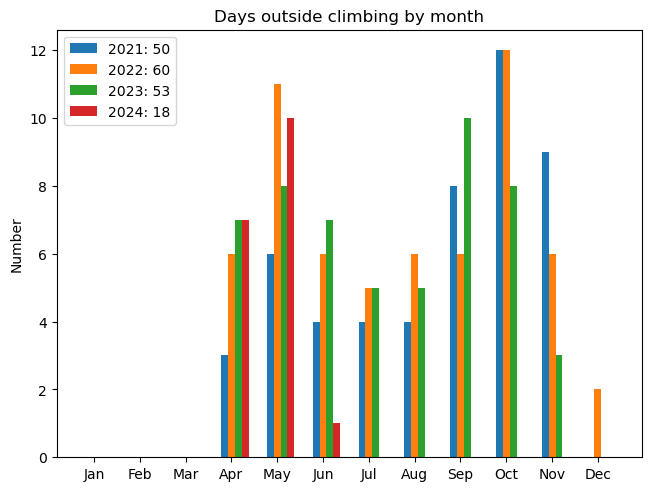

In [18]:
grouped_bar_chart(climbs, func=count_days, title="Days outside climbing")

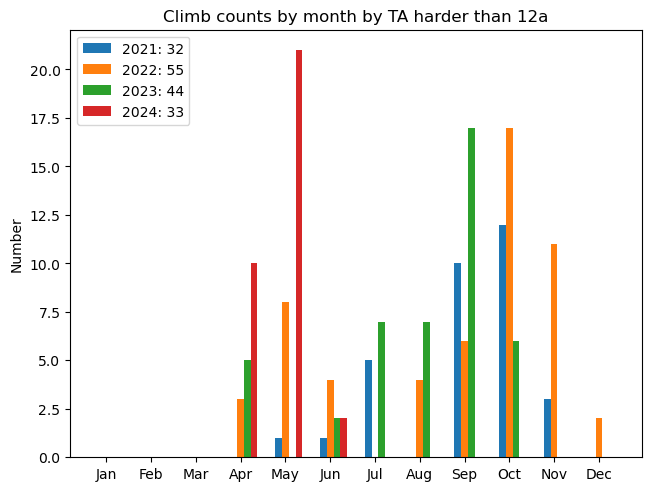

In [19]:
grouped_bar_chart(climbs, climber="TA", grade_min="12a")